###  Small scales on the PySM2 beta synchrotron template

- we subtract the offset term from the $\beta_s$ map  
- we use the fitted power law from the study by Nicoletta Krachmalnicoff to inject small scales on to the spectral index map
- we rescale the large scale $\beta_s$ map by a factor `~1.572` which comes from the SPASS latest results 
- we modulate the small scales on the $\beta_s$ map by the same  modulation map adopted for intensity  

In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 512
lmax = 3 * nside - 1

In [6]:
datadir = Path("data")

In [7]:
output_dir = Path("production-data/synch")

In [8]:
output_nside = 2048

In [9]:
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [10]:
name="temperature"
modulate_amp = hp.alm2map(hp.read_alm(output_dir / "raw" / f"synch_{name}_modulation_alms_lmax{int(lmax):d}.fits").astype(complex), output_nside)


In [11]:
template_dir = "/global/project/projectdirs/cmb/www/pysm-data/pysm_2/"
beta_s_pysm = hp.read_map(template_dir + "synch_beta.fits")
print(beta_s_pysm.mean())
beta_s_pysm_nomono = hp.remove_monopole(beta_s_pysm)
print(beta_s_pysm_nomono.mean())

-2.9999962
7.461009e-08


In [12]:
ell = np.arange(lmax + 1)
cl_spass_fit = 10 ** (-0.82655497) * ell ** (-2.60860208)
cl_spass_fit[0] = 0

/tmp/ipykernel_56422/1304331963.py:2: RuntimeWarning: divide by zero encountered in power
  cl_spass_fit = 10 ** (-0.82655497) * ell ** (-2.60860208)


In [13]:
from pysm3.utils import sigmoid

In [14]:
ell_fit_low = {"TT": 10, "EE": 10, "BB": 10}
ell_fit_high = {"TT": 36, "EE": 36, "BB": 36}

sig_func = sigmoid(ell, x0=ell_fit_high["TT"] - 15, width=ell_fit_high["TT"] / 10)

## Large scales

In [15]:
np.random.seed(444)

cl_spass_fit *= np.sqrt(sig_func)

bs_ss_alm = hp.synalm(cl_spass_fit, lmax=output_lmax)
bs_ss = hp.alm2map(bs_ss_alm, nside=output_nside)

bs_ss *= modulate_amp

In [16]:
## Includes rescaling from S-pass

alm_bs = hp.map2alm(beta_s_pysm_nomono * 1.5722501, lmax=output_lmax, use_pixel_weights=True)

bs_LS_alm = np.empty_like(alm_bs)

bs_LS_alm = hp.almxfl(alm_bs, np.sqrt(1.0 - sig_func))

bs_ls = hp.alm2map(bs_LS_alm, nside=output_nside)

In [17]:
if output_nside > 4096: # only write at 8192

    hp.write_cl(
        output_dir / "raw" / f"synch_small_scales_beta_cl_lmax{output_lmax}.fits",
        cl_spass_fit,
        dtype=np.complex128,
        overwrite=True,
    )

    hp.write_alm(
        output_dir / "raw" / f"synch_largescale_beta_alm_nside{nside}_lmax{lmax:d}_complex64.fits",
        bs_LS_alm,
        lmax=lmax,
        out_dtype=np.complex64,
        overwrite=True,
    )

In [18]:
bs_out = bs_ss + bs_ls - 3.1

In [19]:
output_map_alm = hp.map2alm(bs_out, lmax=output_lmax)

In [20]:
if output_nside > 4096:

    hp.write_alm(
        output_dir / "raw" / f"synch_beta_alm_nside{output_nside}_lmax{output_lmax}_complex64.fits",
        output_map_alm,
        out_dtype = np.complex64,
        overwrite=True,
    )

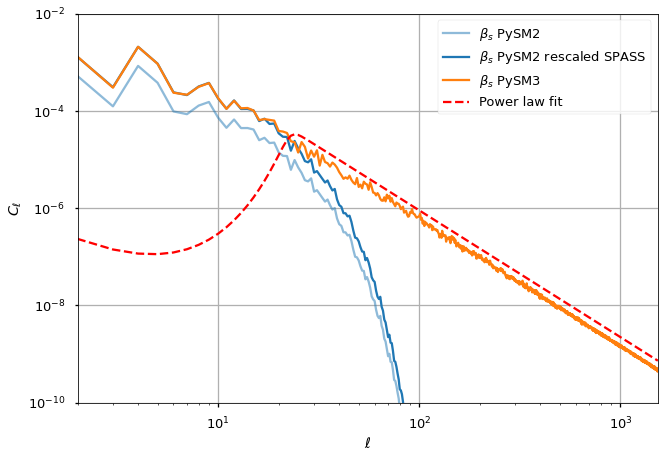

In [21]:
if output_nside < 4096:
    clout = hp.anafast(bs_out, lmax=lmax)
    clin = hp.anafast(beta_s_pysm, lmax=lmax)

    for ii in range(1):
        plt.loglog(ell, clin, alpha=0.5, color="C%d" % ii, label=r"$ \beta_s$ PySM2")
        plt.loglog(
            ell, clin * 1.5722501 ** 2, alpha=1, label=r"$ \beta_s$ PySM2 rescaled SPASS"
        )
        plt.loglog(
            ell,
            clout,
            label=r"$  \beta_s$ PySM3 ",
        )

        plt.grid(True)
        plt.plot(ell, cl_spass_fit, "--", label="Power law fit ", color="red")

        plt.legend()

        plt.ylabel("$ C_\ell $")
        plt.xlabel(("$\ell$"))
        # plt.xlim(10, 55 )
        plt.xlim(2, lmax)
    plt.ylim(1e-10, 1e-2)